# FastHugs
This notebook gives a full run through to fine-tune a text classification model with **HuggingFace 🤗 transformers** and the new **fastai-v2** library.

## Things You Might Like (❤️ ?)
**FastHugsTokenizer:** A tokenizer wrapper than can be used with fastai-v2's tokenizer.

**FastHugsModel:** A model wrapper over the HF models, more or less the same to the wrapper's from HF fastai-v1 articles mentioned below

**Padding:** Padding settings for the padding token index and on whether the transformer prefers left or right padding

**Model Splitters:** Functions to split the classification head from the model backbone in line with fastai-v2's new definition of `Learner` (in `splitters.py`

## Housekeeping
### Pretrained Transformers only for now 😐
Initially, this notebook will only deal with finetuning HuggingFace's pretrained models. It covers BERT, DistilBERT, RoBERTa and ALBERT pretrained classification models only. These are the core transformer model architectures where HuggingFace have added a classification head. HuggingFace also has other versions of these model architectures such as the core model architecture and language model model architectures.

If you'd like to try train a model from scratch HuggingFace just recently published an article on [How to train a new language model from scratch using Transformers and Tokenizers](https://huggingface.co/blog/how-to-train). Its well worth reading to see how their `tokenizers` library can be used, independent of their pretrained transformer models.

### Read these first 👇
This notebooks heavily borrows from [this notebook](https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers) , which in turn is based off of this [tutorial](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta) and accompanying [article](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2). Huge thanks to  Melissa Rajaram and Maximilien Roberti for these great resources, if you're not familiar with the HuggingFace library please given them a read first as they are quite comprehensive.

### fastai-v2  ✌️2️⃣
[This paper](https://www.fast.ai/2020/02/13/fastai-A-Layered-API-for-Deep-Learning/) introduces the v2 version of the fastai library and you can follow and contribute to v2's progress [on the forums](https://forums.fast.ai/). This notebook uses the small IMDB dataset and is based off the [fastai-v2 ULMFiT tutorial](http://dev.fast.ai/tutorial.ulmfit). Huge thanks to Jeremy, Sylvain, Rachel and the fastai community for making this library what it is. I'm super excited about the additinal flexibility v2 brings. 🎉

### Dependencies 📥
If you haven't already, install HuggingFace's `transformers` library with: `pip install transformers`

In [1]:
#hide
# CUDA ERROR DEBUGGING
# https://lernapparat.de/debug-device-assert/
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
#hide
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from splitters import *

import json

In [3]:
#hide
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
df = pd.read_csv(path/'texts.csv')

## FastHugs Tokenizer
This tokenizer wrapper is initialised with the pretrained HF tokenizer, you can also specify the max_seq_len if you want longer/shorter sequences. Given text it returns tokens and adds separator tokens depending on the model type being used.

In [4]:
class FastHugsTokenizer():
    """ 
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_name : model type set by the user
        max_seq_len : override default sequence length, typically 512 for bert-like models
        sentence_pair : whether a single sentence (sequence) or pair of sentences are used
    """
    def __init__(self, transformer_tokenizer=None, model_name = 'roberta', max_seq_len=None, 
                 sentence_pair=False, **kwargs): 
        self.tok, self.max_seq_len=transformer_tokenizer, max_seq_len
        if self.max_seq_len:
            if self.max_seq_len<=self.tok.max_len: 
                print('WARNING: max_seq_len is larger than the model default transformer_tokenizer.max_len')
        if sentence_pair: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_sentences_pair) 
        else: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_single_sentence)
        self.model_name = model_name
        
    def do_tokenize(self, o:str):
        """Limits the maximum sequence length and add the special tokens"""
        CLS, SEP=self.tok.cls_token, self.tok.sep_token
        
        # Add prefix space, depending on model selected
        if 'roberta' in model_name: tokens=self.tok.tokenize(o, add_prefix_space=True)[:self.max_seq_len]
        else: tokens = self.tok.tokenize(o)[:self.max_seq_len]
        
        # order of 'tokens', 'SEP' and 'CLS'
        if 'xlnet' in model_name: return tokens + [SEP] +  [CLS]
        else: return [CLS] + tokens + [SEP]

    def __call__(self, items): 
        for o in items: yield self.do_tokenize(o)

## FastHugs Model
This `nn.module` wraps the pretrained transformer model and initialises it with its config file. 

The `forward` of this module is taken straight from Melissa's notebook above and its purpose is to create the attention mask and grab only the logits from the output of the model (as the HappyFace transformer models also output the loss).

In [5]:
class FastHugsModel(nn.Module):
    'Inspired by https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data'
    def __init__(self, transformer_cls, config_dict, n_class, pretrained=True):
        super(FastHugsModel, self).__init__()
        self.config = config_dict  
        self.config._num_labels = n_class
        # load model
        if pretrained: self.transformer = transformer_cls.from_pretrained(model_name, config=self.config)
        else: self.transformer = transformer_cls.from_config(config=self.config)
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) 
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

## The HuggingFace bit

### Define HuggingFace Model + Config
- `AutoModelForSequenceClassification` will define our model. When this is padded to the `FastHugsModel` class below then model will be instantiated and the weights downloaded (if you are using a pretrained model)
- `AutoConfig` will define the model architecture and settings
- `model_name` is the model architecture (and optionally model weights) you'd like to use.
    - Models tested: `bert-base-uncased`, `roberta-base`, `distilbert-base-cased`, `albert-base-v2`
    - You can find all of HuggingFace's models at [https://huggingface.co/models](https://huggingface.co/models), although not all of them are supported by `AutoModel`,`AutoConfig` and `AutoTokenizer`

In [6]:
model_name = 'roberta-base' 
model_class = AutoModelForSequenceClassification
config_dict = AutoConfig.from_pretrained(model_name)

### HuggingFace Config changes
Some config settings can be changed even when using pretrained weights. For example in the `FastHugsModel` class below `_num_labels` is set when the model (pretrained or not) is instantiated, depending on how many classes you have in your dataloader.

When creating a **non-pretrained** model you can load a config with:

> `config_dict = AutoConfig.for_model(model_name)`

Alternatively you could load a pretrained config and modify that. For example if your are **not** using a pretrained model you can change the size of your input embeddings by changing `config_dict.max_position_embeddings = 1024`. (This won't work when using pretrained models as the pre-trained weights need the default `max_position_embeddings` size).

### HuggingFace Tokenizer & Vocab
- `AutoTokenizer` will load our tokenizer and enable us grab our vocab

fastai expects `vocab` to be a list, however HuggingFace's `get_vocab` returns a `token : index` dict. We need to convert this dict to a list to be able to use it in fastai

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_vocab=tokenizer.get_vocab() 
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
len(tokenizer_vocab_ls)

50265

## The Fastai bit
### Get fastai model splitter function
In order to be able to fine-tune our classifier head we need to first split the HuggingFace model's classifier head from the body. These functions are dependent on the specific architecture and can be found in `splitter.py` of this repo

In [8]:
splitter_nm = model_name.split('-')[0] + '_cls_splitter'
model_splitter = splitters[splitter_nm]

### `fasthugstok` and our `tok_fn`
Lets incorporate the `tokenizer` from HuggingFace into fastai-v2's framework by specifying a function called `fasthugstok` that we can then pass on to `Tokenizer.from_df`. (Note `.from_df` is the only method I have tested)

#### Max Seqence Length
`max_seq_len` is the longest sequece our tokenizer will output. We can also the max sequence length for the tokenizer by changing `max_seq_len`. It uses the tokenizer's default, typically `512`. `1024` or even `2048` can also be used depending on your GPU memory. Note when using pretrained models you won't be able to use a `max_seq_len` larger than the default. 

In [9]:
max_seq_len = None  
sentence_pair=False

fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer=tokenizer, model_name=model_name, 
                      max_seq_len=max_seq_len, sentence_pair=sentence_pair)

Set up fastai's `Tokenizer.from_df`, we pass `rules=[]` to override fastai's default text processing rules

In [10]:
fastai_tokenizer = Tokenizer.from_df(text_cols='text', res_col_name='text', tok_func=fasthugstok, rules=[])

## Setup Dataloaders
### Create Dataset
Lets add our custom tokenizer function (`tok_fn`) and `transformer_vocab` here

In [11]:
splits = ColSplitter()(df)
x_tfms = [attrgetter("text"), fastai_tokenizer, Numericalize(vocab=tokenizer_vocab_ls)]
dsets = Datasets(df, splits=splits, tfms=[x_tfms, [attrgetter("label"), Categorize()]], dl_type=SortedDL)

### Padding
We need to make sure our padding is done correctly as some transformer models prefer padding on the left while others prefer it on the right. `tokenizer.padding_side` will tell us which side is correct. e.g., BERT, Roberta prefers padding to the right, so we set `pad_first=False`

In [12]:
def transformer_padding(tokenizer=None, max_seq_len=None, sentence_pair=False): 
    if tokenizer.padding_side == 'right': pad_first=False
    else: pad_first=True
    max_seq_len = ifnone(max_seq_len, tokenizer.max_len) 
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=tokenizer.pad_token_id, seq_len=max_seq_len)

### Dataloaders

In [13]:
bs = 4
padding=transformer_padding(tokenizer)
dls = dsets.dataloaders(bs=bs, before_batch=[padding])

In [14]:
dls.show_batch(max_n=3, trunc_at=60)

,text,category
0,"<s> ĠI Ġwas Ġfortunate Ġenough Ġto Ġmeet ĠGeorge ĠPal Ġ( and Ġstill Ġhave Ġmy ĠDS : TM OB Ġposter Ġaut ographed Ġby Ġhim ) Ġat Ġa Ġconvention Ġshortly Ġafter Ġthe Ġrelease , Ġand Ġasked Ġhim Ġwhy Ġhe Ġchose Ġto Ġdo Ġthe Ġfilm Ġ"" camp "". ĠBefore Ġhe Ġcould Ġanswer , Ġtwo Ġstudio Ġfl acks Ġintercepted Ġand Ġlect ured Ġme Ġon",negative
1,"<s> ĠD ressed Ġto ĠKill Ġstarts Ġoff Ġwith ĠKate ĠMiller Ġ( Ang ie ĠDickinson ) Ġhaving Ġa Ġsexually Ġexplicit Ġnightmare , Ġlater Ġon Ġthat Ġday Ġshe Ġvisits Ġher Ġpsychiatrist ĠDr . ĠRobert ĠElliott Ġ( Michael ĠC aine ) Ġfor Ġa Ġsession Ġin Ġwhich Ġshe Ġadmits Ġto Ġbe Ġsexually Ġfrustrated Ġ& Ġun ful filled Ġin Ġher Ġcurrent Ġmarriage . ĠKate Ġthen",positive
2,"<s> ĠSHALL OW ĠG RA VE Ġbegins Ġwith Ġeither Ġa Ġtribute Ġor Ġa Ġrip Ġoff Ġof Ġthe Ġshower Ġscene Ġin ĠPS Y CHO . Ġ( I 'm Ġleaning Ġtoward Ġrip Ġoff .) ĠAfter Ġthat Ġit Ġgets Ġworse Ġand Ġthen Ġsurprisingly Ġgets Ġbetter , Ġalmost Ġto Ġthe Ġpoint Ġof Ġbeing Ġoriginal . ĠBad Ġacting Ġand Ġamateur ish Ġdirecting Ġbog Ġdown Ġa",negative


### (Alternatively) Factory dataloader
Here we set:
- `tok_tfm=tok_fn` to use our HF tokenizer
- `text_vocab=transformer_vocab` to load our pretrained vocab
- `before_batch=transformer_padding(transformer_tokenizer)` to use our custom padding function 

In [15]:
# Factory
fct_dls = TextDataLoaders.from_df(df, text_col="text", tok_tfm=fastai_tokenizer, text_vocab=tokenizer_vocab_ls,
                              before_batch=[padding],
                              label_col='label', valid_col='is_valid', bs=bs)

In [16]:
fct_dls.show_batch(max_n=3, trunc_at=60)

,text,category
0,"<s> ĠI Ġwas Ġfortunate Ġenough Ġto Ġmeet ĠGeorge ĠPal Ġ( and Ġstill Ġhave Ġmy ĠDS : TM OB Ġposter Ġaut ographed Ġby Ġhim ) Ġat Ġa Ġconvention Ġshortly Ġafter Ġthe Ġrelease , Ġand Ġasked Ġhim Ġwhy Ġhe Ġchose Ġto Ġdo Ġthe Ġfilm Ġ"" camp "". ĠBefore Ġhe Ġcould Ġanswer , Ġtwo Ġstudio Ġfl acks Ġintercepted Ġand Ġlect ured Ġme Ġon",negative
1,"<s> Ġ**** Don 't Ġread Ġthis Ġreview Ġif Ġyou Ġwant Ġthe Ġshocking Ġconclusion Ġof Ġ"" The ĠCr ater ĠLake ĠMonster "" Ġto Ġbe Ġa Ġtotal Ġsurprise **** < br Ġ/ >< br Ġ/> A Ġclay m ation Ġpl es ios aur Ġrises Ġfrom Ġthe Ġdepths Ġof ĠCr ater ĠLake Ġto Ġwre ak Ġhavoc Ġon Ġa Ġgroup Ġof Ġlocal Ġred ne",negative
2,"<s> ĠThis Ġis Ġthe Ġlast Ġof Ġfour Ġsw ash buck lers Ġfrom ĠFrance ĠI 've Ġscheduled Ġfor Ġviewing Ġduring Ġthis ĠChristmas Ġseason : Ġthe Ġothers Ġ( in Ġorder Ġof Ġviewing ) Ġwere Ġthe Ġun inspired ĠTHE ĠBLACK ĠT UL IP Ġ( 1964 ; Ġfrom Ġthe Ġsame Ġdirector Ġas Ġthis Ġone Ġbut Ġnot Ġnearly Ġas Ġgood ), Ġthe Ġsurprisingly Ġeffective ĠL",positive


## Create our learner

In [17]:
opt_func = partial(Adam, decouple_wd=True)
loss = LabelSmoothingCrossEntropy()

fasthugs_model = FastHugsModel(transformer_cls=model_class, config_dict=config_dict, n_class=dls.c, pretrained=True)

learn = Learner(dls, fasthugs_model, opt_func=opt_func, splitter=model_splitter, 
                loss_func=loss, metrics=[accuracy]).to_fp16()

### Stage 1 training
Lets freeze the model backbone and only train the classifier head. `freeze_to(1)` means that only the classifier head is trainable

In [18]:
learn.freeze_to(1)  

In [19]:
learn.summary()

FastHugsModel (Input shape: ['4 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            4 x 512 x 768        38,603,520 False     
________________________________________________________________
Embedding            4 x 512 x 768        394,752    False     
________________________________________________________________
Embedding            4 x 512 x 768        768        False     
________________________________________________________________
LayerNorm            4 x 512 x 768        1,536      False     
________________________________________________________________
Dropout              4 x 512 x 768        0          False     
________________________________________________________________
Linear               4 x 512 x 768        590,592    False     
________________________________________________________________
Linear               4 x 512 x 768        590,592    False     
_________________________________________________________

Lets find a learning rate to train our classifier head

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=0.10000000149011612)

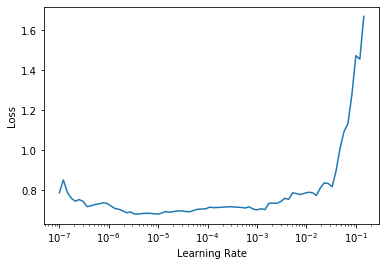

In [20]:
learn.lr_find(suggestions=True)

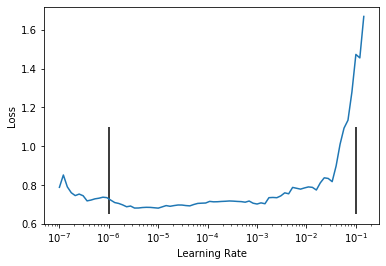

In [22]:
learn.recorder.plot_lr_find()
plt.vlines(9.999e-7, 0.65, 1.1)
plt.vlines(0.10, 0.65, 1.1)

In [23]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.692172,0.653464,0.550000,00:07
1,0.573368,0.591558,0.635000,00:07
2,0.522324,0.533852,0.810000,00:07


In [23]:
learn.save('roberta-fasthugs-stg1-1e-3')

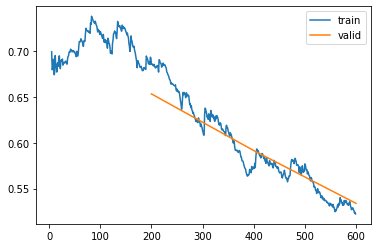

In [24]:
learn.recorder.plot_loss()

### Stage 2 training
And now lets train the full model with differential learning rates

In [25]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.03981071710586548)

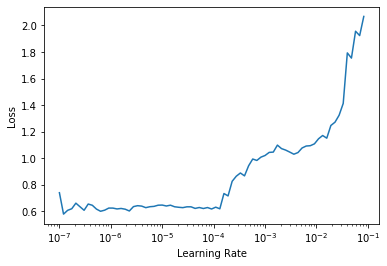

In [26]:
learn.lr_find(suggestions=True)

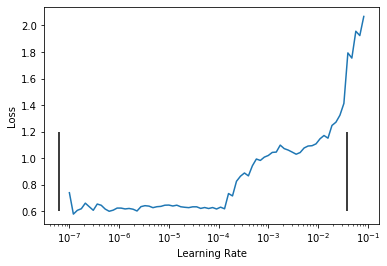

In [27]:
learn.recorder.plot_lr_find()
plt.vlines(6.30e-8, 0.6, 1.2)
plt.vlines(0.039, 0.6, 1.2)

In [28]:
learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.425518,0.354511,0.910000,00:31
1,0.278425,0.372734,0.910000,00:32
2,0.272590,0.366681,0.925000,00:31


In [ ]:
learn.save('roberta-fasthugs-stg2-3e-5')

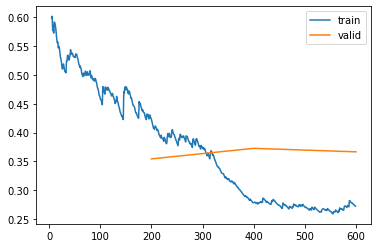

In [29]:
learn.recorder.plot_loss()

## Lets Look at the model's predictions

In [30]:
learn.predict("This was a really good movie, i loved it")

('positive', tensor(1), tensor([0.1498, 0.8502]))

In [31]:
from fastai2.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

In [32]:
interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,"<s> ĠThis Ġmovie Ġis Ġhorrible - Ġin Ġa Ġ' so Ġbad Ġit 's Ġgood ' Ġkind Ġof Ġway .< br Ġ/ >< br Ġ/> The Ġstoryline Ġis Ġre h ashed Ġfrom Ġso Ġmany Ġother Ġfilms Ġof Ġthis Ġkind , Ġthat ĠI 'm Ġnot Ġgoing Ġto Ġeven Ġbother Ġdescribing Ġit . ĠIt 's Ġa Ġsword / s or cery Ġpicture , Ġhas Ġa Ġkid Ġhoping Ġto Ġrealize Ġhow Ġimportant Ġhe Ġis Ġin Ġthis Ġworld , Ġhas Ġa Ġ"" nom adic "" Ġadventurer , Ġan Ġevil Ġaide / s orce rer , Ġa Ġprincess , Ġa Ġhairy Ġcreature .... you Ġget Ġthe Ġpoint .< br Ġ/ >< br Ġ/> The Ġfirst Ġtime ĠI Ġcaught Ġthis Ġmovie Ġwas Ġduring Ġa Ġvery Ġharsh Ġwinter . ĠI Ġdon 't Ġknow Ġwhy ĠI Ġdecided Ġto Ġcontinue Ġwatching Ġit Ġfor Ġan Ġextra Ġfive Ġminutes Ġbefore Ġturning Ġthe Ġchannel , Ġbut Ġwhen ĠI Ġcaught Ġsite Ġof ĠGulf ax",positive,negative,0.970687747001648,3.354750156402588
1,"<s> ĠIn Ġ17 th ĠCentury ĠJapan , Ġthere Ġlived Ġa Ġsamurai Ġwho Ġwould Ġset Ġthe Ġstandard Ġfor Ġthe Ġages . ĠHis Ġname Ġwas ĠMay eda . ĠHe Ġis Ġsent Ġon Ġan Ġepic Ġjourney Ġacross Ġthe Ġworld Ġto Ġacquire Ġ5 , 000 Ġmus cats Ġfrom Ġthe ĠKing Ġof ĠSpain . ĠWhilst Ġat Ġsea Ġa Ġviolent Ġstorm Ġswall ows Ġtheir Ġprecious Ġgold Ġintended Ġto Ġbuy Ġthe Ġweapons Ġand Ġalmost Ġtakes Ġtheir Ġlives . ĠMay eda Ġmust Ġbattle Ġall Ġodds Ġto Ġsurvive Ġand Ġthe Ġsecure Ġthe Ġfate Ġof Ġhis Ġbeloved ĠJapan . ĠShogun ĠMay eda Ġis Ġa Ġmulti Ġmillion Ġdollar Ġaction Ġadventure Ġepic Ġset Ġacross Ġthree Ġcontinents .< br Ġ/ >< br Ġ/> Star ring Ġcinema Ġlegends ĠSho ĠKos ugi Ġ( T ench u : ĠStealth ĠAssassins ), ĠChristopher ĠLee Ġ( Star ĠWars , ĠLord Ġof Ġthe ĠRings ĠTrilogy ), ĠJohn ĠRh ys ĠDavies Ġ( Lord Ġof Ġthe ĠRings ĠTrilogy , ĠIndiana ĠJones",negative,positive,0.9588471055030823,3.033039093017578
2,"<s> Ġ"" How ĠTo ĠLose ĠFriends Ġ& ĠAlien ate ĠPeople "" Ġis Ġnot Ġbased Ġon ĠTiger ĠWoods ' Ġinf idel ities . ĠIt Ġis Ġa Ġmediocre Ġromantic Ġcomedy Ġbased Ġon ĠToby ĠYoung 's Ġbook Ġon Ġhis Ġexperiences Ġworking Ġas Ġa Ġjournalist Ġcovering Ġcelebrities . ĠThe Ġfilm Ġstars ĠSimon ĠPe gg Ġas ĠSidney ĠYoung , Ġa Ġz any ĠBritish Ġjournalist Ġwho Ġtakes Ġa Ġjob Ġin Ġan Ġillustrious Ġcelebrity Ġmagazine Ġin ĠNew ĠYork . ĠYoung Ġis Ġrestless Ġin Ġgetting Ġcaught Ġup Ġall Ġtype Ġof Ġshenanigans Ġto Ġalien ate Ġall Ġaround Ġhim , Ġhence Ġmovie Ġtitle . ĠHe Ġis Ġupro arious , Ġdaring , Ġand Ġmor onic . ĠBut Ġnevertheless Ġfor Ġsome Ġvery Ġbizarre Ġreason , Ġhe Ġis Ġa Ġsomewhat Ġlik able Ġcharacter . ĠSidney Ġbe friends Ġa Ġfellow Ġjournalist , Ġthe Ġcomposed ĠAlison ĠOlsen , Ġplayed Ġquite Ġadm ir ably Ġby ĠKirst en ĠDun st . ĠHowever , ĠSidney Ġis Ġprimarily Ġlonging",positive,negative,0.942081868648529,2.7092723846435547
